In [14]:
# Cell 1: Import necessary libraries
import os
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import torch.optim as optim
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

In [15]:
# Cell 2: Define the dataset class
class CoronaryDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        # Get all jpg files and their corresponding labels from txt files
        self.samples = []
        for fname in os.listdir(image_dir):
            if fname.endswith(".jpg"):
                img_path = os.path.join(image_dir, fname)
                txt_path = os.path.join(image_dir, fname.replace(".jpg", ".txt"))
                # Check if the txt file exists
                if os.path.exists(txt_path):
                    try:
                        with open(txt_path, 'r') as f:
                            label = int(f.read().strip())
                        self.samples.append((img_path, label))
                    except (ValueError, FileNotFoundError):
                        print(f"Skipping {fname}: Issue with label file")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label, img_path  # Return path for identification

In [16]:
# Cell 3: Set up dataset and data loaders
# Set the correct dataset path
PROCESSED_DIR = "arterydir"

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load dataset
dataset = CoronaryDataset(PROCESSED_DIR, transform=transform)
print(f"Total samples found: {len(dataset)}")

# Split into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_data, val_data = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

Total samples found: 4238


In [17]:
# Cell 4: Set up the models
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize EfficientNet-B0 model
effnet_model = models.efficientnet_b0(pretrained=True)
effnet_model.classifier[1] = nn.Linear(effnet_model.classifier[1].in_features, 3)  # 3 classes
effnet_model.load_state_dict(torch.load("efficientnet_b0_artery_model.pth", map_location=device))
effnet_model = effnet_model.to(device)
effnet_model.eval()

# Initialize ResNet50 model
resnet_model = models.resnet50(pretrained=True)
num_ftrs = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(num_ftrs, 3)  # 3 classes
resnet_model.load_state_dict(torch.load("resnet50_artery_model.pth", map_location=device))
resnet_model = resnet_model.to(device)
resnet_model.eval()

# Initialize VGG16 model
vgg_model = models.vgg16(pretrained=True)
vgg_model.classifier[6] = nn.Linear(vgg_model.classifier[6].in_features, 3)  # 3 classes
vgg_model.load_state_dict(torch.load("vgg16_artery_model.pth", map_location=device))
vgg_model = vgg_model.to(device)
vgg_model.eval()

Using device: cuda


c:\ProgramData\miniconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\ProgramData\miniconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\sricharan\AppData\Local\Temp\ipykernel_25324\348854435.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytor

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [18]:
# Cell 5: Create Ensemble Class
class EnsembleModel:
    def __init__(self, models, weights=None):
        self.models = models
        # If weights are not provided, use equal weighting
        if weights is None:
            self.weights = [1/len(models)] * len(models)
        else:
            # Normalize weights to sum to 1
            total = sum(weights)
            self.weights = [w/total for w in weights]
    
    def predict(self, image_tensor):
        # Run inference with each model
        all_outputs = []
        for i, model in enumerate(self.models):
            output = model(image_tensor)
            # Apply softmax to get probabilities
            probabilities = torch.nn.functional.softmax(output, dim=1)
            # Apply weight to this model's output
            weighted_probs = probabilities * self.weights[i]
            all_outputs.append(weighted_probs)
        
        # Sum the weighted probabilities from all models
        ensemble_output = sum(all_outputs)
        
        # Get the predicted class (index of max probability)
        _, predicted = torch.max(ensemble_output, 1)
        return predicted, ensemble_output

In [19]:
# Cell 6: Evaluate each individual model first
def evaluate_model(model, data_loader, name="Model"):
    model.eval()
    all_preds = []
    all_labels = []
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels, _ in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = 100 * correct / total
    print(f"{name} Accuracy: {accuracy:.2f}%")
    
    return all_preds, all_labels, accuracy

In [20]:
# Cell 7: Evaluate individual models
print("Evaluating individual models on validation set...")
_, _, effnet_acc = evaluate_model(effnet_model, 
                                DataLoader(val_data, batch_size=32, shuffle=False), 
                                "EfficientNet-B0")
_, _, resnet_acc = evaluate_model(resnet_model, 
                                DataLoader(val_data, batch_size=32, shuffle=False), 
                                "ResNet50")
_, _, vgg_acc = evaluate_model(vgg_model, 
                             DataLoader(val_data, batch_size=32, shuffle=False), 
                             "VGG16")

Evaluating individual models on validation set...
EfficientNet-B0 Accuracy: 98.58%
ResNet50 Accuracy: 96.93%
VGG16 Accuracy: 90.09%


In [21]:
# Cell 8: Create weighted ensemble based on model performances
# Use accuracy scores to determine weights
weights = [effnet_acc, resnet_acc, vgg_acc]
ensemble = EnsembleModel([effnet_model, resnet_model, vgg_model], weights=weights)

In [22]:
# Cell 9: Evaluate ensemble model
ensemble_preds = []
all_labels = []
ensemble_probs = []
total = 0
correct = 0

val_loader_with_paths = DataLoader(val_data, batch_size=32, shuffle=False)

with torch.no_grad():
    for images, labels, paths in val_loader_with_paths:
        images, labels = images.to(device), labels.to(device)
        
        # Get ensemble predictions
        predicted, probs = ensemble.predict(images)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        ensemble_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        ensemble_probs.extend(probs.cpu().numpy())

ensemble_acc = 100 * correct / total
print(f"Ensemble Model Accuracy: {ensemble_acc:.2f}%")

Ensemble Model Accuracy: 98.70%


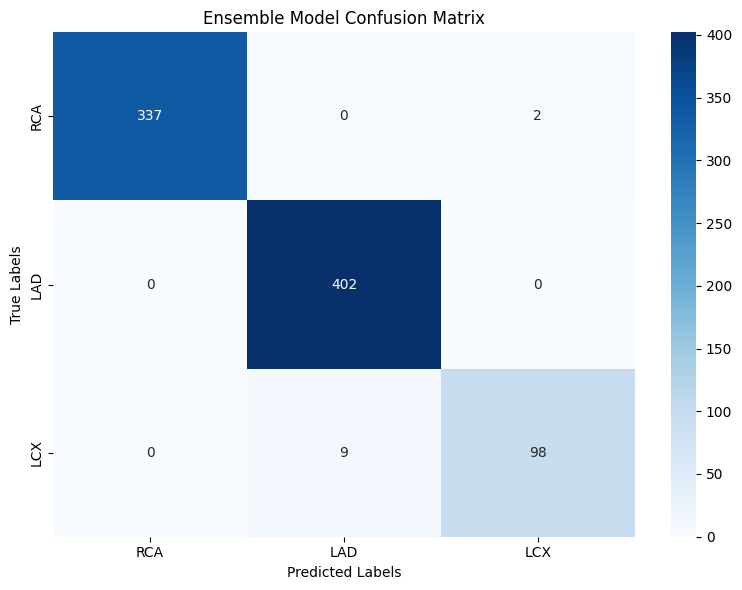

In [23]:
# Cell 10: Plot Confusion Matrix for Ensemble
class_names = ['RCA', 'LAD', 'LCX']
cm = confusion_matrix(all_labels, ensemble_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Ensemble Model Confusion Matrix')
plt.tight_layout()
plt.savefig('ensemble_confusion_matrix.png')
plt.show()

In [24]:
# Cell 11: Display Classification Report for Ensemble
print("\nEnsemble Classification Report:")
report = classification_report(all_labels, ensemble_preds, target_names=class_names)
print(report)


Ensemble Classification Report:
              precision    recall  f1-score   support

         RCA       1.00      0.99      1.00       339
         LAD       0.98      1.00      0.99       402
         LCX       0.98      0.92      0.95       107

    accuracy                           0.99       848
   macro avg       0.99      0.97      0.98       848
weighted avg       0.99      0.99      0.99       848



In [25]:
# Cell 12: Fine-tune the ensemble
# Let's create a more sophisticated ensemble by training a meta-classifier
# We'll use the predictions from our base models as features

# Create a dataset for the meta-learner (stacking ensemble)
class MetaDataset(Dataset):
    def __init__(self, data_loader, models):
        self.models = models
        self.features = []
        self.labels = []
        
        # Generate features from base models
        with torch.no_grad():
            for images, labels, _ in data_loader:
                images, labels = images.to(device), labels.to(device)
                
                # Collect predictions from each model
                model_outputs = []
                for model in models:
                    outputs = model(images)
                    probs = torch.nn.functional.softmax(outputs, dim=1)
                    model_outputs.append(probs)
                
                # Concatenate all model outputs for each sample
                batch_features = torch.cat(model_outputs, dim=1)  # Shape: [batch_size, 3*num_models]
                
                self.features.extend(batch_features.cpu().numpy())
                self.labels.extend(labels.cpu().numpy())
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return torch.tensor(self.features[idx], dtype=torch.float), self.labels[idx]

In [26]:
# Cell 13: Create and train the meta-classifier
print("Creating meta-classifier dataset...")
meta_train_loader = DataLoader(train_data, batch_size=32, shuffle=False)
meta_val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

meta_train_dataset = MetaDataset(meta_train_loader, [effnet_model, resnet_model, vgg_model])
meta_val_dataset = MetaDataset(meta_val_loader, [effnet_model, resnet_model, vgg_model])

meta_train_loader = DataLoader(meta_train_dataset, batch_size=32, shuffle=True)
meta_val_loader = DataLoader(meta_val_dataset, batch_size=32, shuffle=False)

# Define meta-classifier model
class MetaClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MetaClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Initialize meta-classifier (input size is 3 classes * 3 models = 9)
meta_classifier = MetaClassifier(9, 3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(meta_classifier.parameters(), lr=0.001)

Creating meta-classifier dataset...


In [27]:
# Cell 14: Training and validation for meta-classifier
# Lists to store metrics for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
print("Training meta-classifier...")
num_epochs = 50  # More epochs for meta-classifier since it's a smaller model

for epoch in range(num_epochs):
    # Training
    meta_classifier.train()
    train_loss = 0
    correct = 0
    total = 0
    
    for features, labels in meta_train_loader:
        features, labels = features.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = meta_classifier(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_train_loss = train_loss / len(meta_train_loader)
    epoch_train_acc = 100 * correct / total
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)
    
    # Validation
    meta_classifier.eval()
    val_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for features, labels in meta_val_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = meta_classifier(features)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_val_loss = val_loss / len(meta_val_loader)
    epoch_val_acc = 100 * correct / total
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%, Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%")

# Save the meta-classifier
torch.save(meta_classifier.state_dict(), "meta_classifier_model.pth")
print("Meta-classifier saved to meta_classifier_model.pth")

Training meta-classifier...
Epoch 10/50, Train Loss: 0.0316, Train Acc: 99.12%, Val Loss: 0.0329, Val Acc: 99.29%
Epoch 20/50, Train Loss: 0.0256, Train Acc: 99.32%, Val Loss: 0.0349, Val Acc: 99.29%
Epoch 30/50, Train Loss: 0.0265, Train Acc: 99.29%, Val Loss: 0.0374, Val Acc: 99.17%
Epoch 40/50, Train Loss: 0.0255, Train Acc: 99.38%, Val Loss: 0.0390, Val Acc: 99.29%
Epoch 50/50, Train Loss: 0.0239, Train Acc: 99.35%, Val Loss: 0.0405, Val Acc: 99.29%
Meta-classifier saved to meta_classifier_model.pth


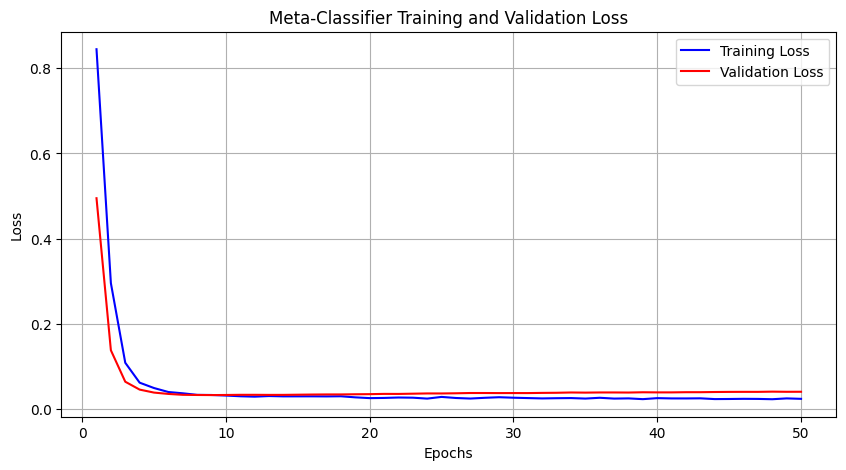

In [28]:
# Cell 15: Plot Loss Graph
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, 'b-', label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, 'r-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Meta-Classifier Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.savefig('ensemble_loss_graph.png')
plt.show()

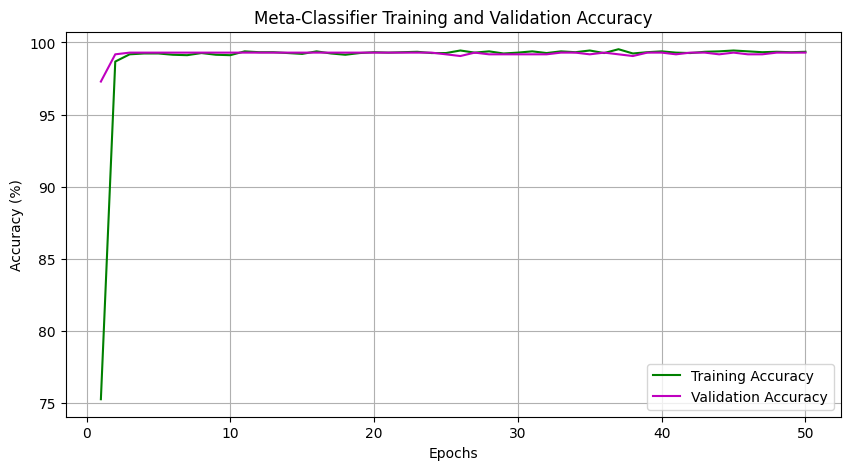

In [29]:
# Cell 16: Plot Accuracy Graph
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, 'g-', label='Training Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, 'm-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Meta-Classifier Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('ensemble_accuracy_graph.png')
plt.show()

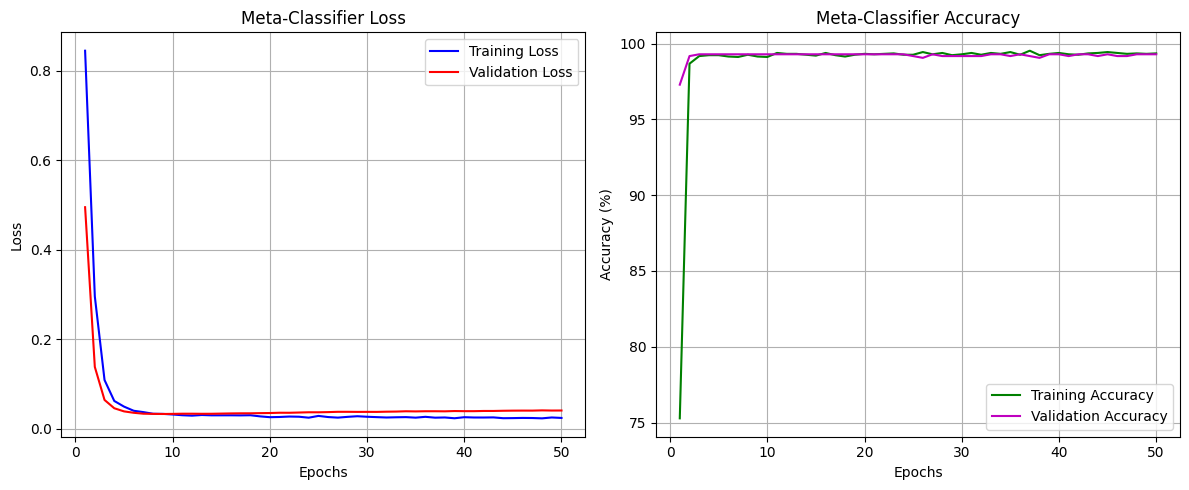

In [30]:
# Cell 17: Plot combined Train vs Validation Graph
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, 'b-', label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, 'r-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Meta-Classifier Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, 'g-', label='Training Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, 'm-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Meta-Classifier Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('ensemble_train_vs_val_graph.png')
plt.show()

In [31]:
# Cell 18: Evaluate stacked ensemble's final performance
# Generate predictions using the meta-classifier
meta_preds = []
all_true_labels = []

meta_classifier.eval()
with torch.no_grad():
    for features, labels in meta_val_loader:
        features, labels = features.to(device), labels.to(device)
        outputs = meta_classifier(features)
        _, predicted = torch.max(outputs.data, 1)
        
        meta_preds.extend(predicted.cpu().numpy())
        all_true_labels.extend(labels.cpu().numpy())

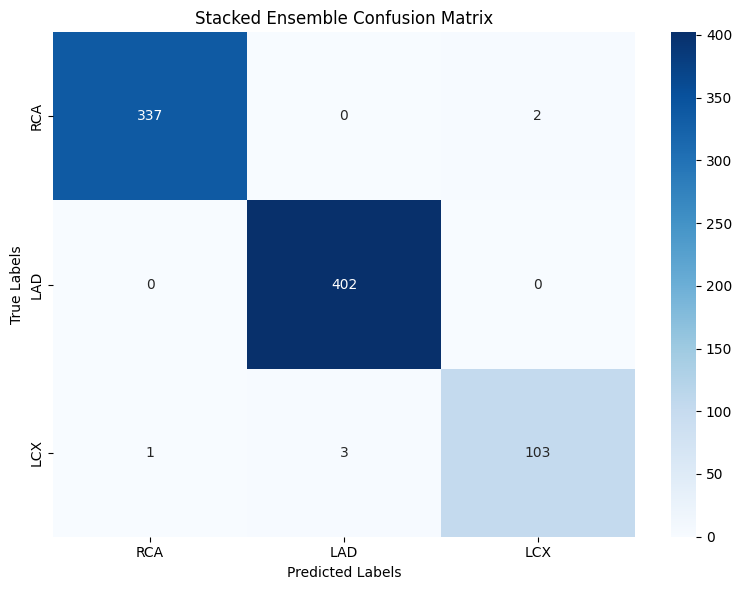

In [ ]:
# Cell 19: Plot final stacked ensemble Confusion Matrix
cm = confusion_matrix(all_true_labels, meta_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Stacked Ensemble Confusion Matrix')
plt.tight_layout()
plt.savefig('stacked_ensemble_confusion_matrix.png')
plt.show()

In [33]:
# Cell 20: Display final Classification Report
stacked_acc = accuracy_score(all_true_labels, meta_preds) * 100
print(f"\nStacked Ensemble Accuracy: {stacked_acc:.2f}%")
print("\nStacked Ensemble Classification Report:")
report = classification_report(all_true_labels, meta_preds, target_names=class_names)
print(report)


Stacked Ensemble Accuracy: 99.29%

Stacked Ensemble Classification Report:
              precision    recall  f1-score   support

         RCA       1.00      0.99      1.00       339
         LAD       0.99      1.00      1.00       402
         LCX       0.98      0.96      0.97       107

    accuracy                           0.99       848
   macro avg       0.99      0.99      0.99       848
weighted avg       0.99      0.99      0.99       848



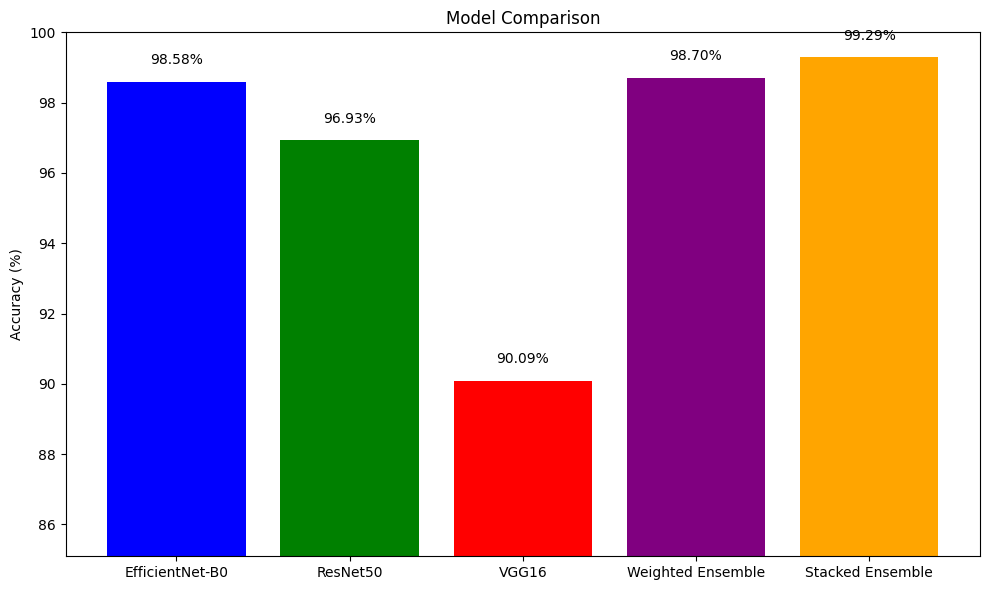

In [ ]:
# Cell 21: Compare all models
model_names = ['EfficientNet-B0', 'ResNet50', 'VGG16', 'Weighted Ensemble', 'Stacked Ensemble']
accuracies = [effnet_acc, resnet_acc, vgg_acc, ensemble_acc, stacked_acc]

plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies, color=['blue', 'green', 'red', 'purple', 'orange'])
plt.ylabel('Accuracy (%)')
plt.title('Model Comparison')
plt.ylim(min(accuracies) - 5, 100)
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.5, f"{v:.2f}%", ha='center')
plt.tight_layout()
plt.savefig('model_comparison.png')
plt.show()

In [35]:
# Cell 22: Define a comprehensive prediction function using the ensemble
def predict_artery_ensemble(img_path, base_models, meta_classifier, transform):
    # Load and preprocess the image
    image = cv2.imread(img_path)
    if image is None:
        print(f"Error: Could not load image from {img_path}")
        return None
    
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_pil = Image.fromarray(image_rgb)
    image_tensor = transform(image_pil).unsqueeze(0).to(device)
    
    # Get predictions from base models
    model_outputs = []
    base_preds = []
    
    for model in base_models:
        model.eval()
        with torch.no_grad():
            output = model(image_tensor)
            probs = torch.nn.functional.softmax(output, dim=1)
            model_outputs.append(probs)
            _, pred = torch.max(output, 1)
            base_preds.append(pred.item())
    
    # Use the meta-classifier for final prediction
    meta_features = torch.cat(model_outputs, dim=1)
    
    meta_classifier.eval()
    with torch.no_grad():
        meta_output = meta_classifier(meta_features)
        _, meta_pred = torch.max(meta_output, 1)
    
    label_map = {0: "RCA", 1: "LAD", 2: "LCX"}
    base_model_names = ["EfficientNet-B0", "ResNet50", "VGG16"]
    ensemble_pred = label_map[meta_pred.item()]
    
    # Prepare results including individual model predictions
    results = {
        "ensemble_prediction": ensemble_pred,
        "individual_predictions": {
            model_name: label_map[pred] 
            for model_name, pred in zip(base_model_names, base_preds)
        }
    }
    
    return results

In [36]:
# Cell 23: Test the ensemble on a sample image
test_img_path = os.path.join(PROCESSED_DIR, "1_161.jpg")  # Update this to a specific image path that exists
if os.path.exists(test_img_path):
    results = predict_artery_ensemble(
        test_img_path, 
        [effnet_model, resnet_model, vgg_model], 
        meta_classifier, 
        transform
    )
    print(f"Ensemble Predicted Artery: {results['ensemble_prediction']}")
    print("Individual model predictions:")
    for model_name, pred in results['individual_predictions'].items():
        print(f"  - {model_name}: {pred}")
else:
    print(f"Test image not found at {test_img_path}")
    # Find first available image for testing
    sample_images = [f for f in os.listdir(PROCESSED_DIR) if f.endswith('.jpg')]
    if sample_images:
        test_img_path = os.path.join(PROCESSED_DIR, sample_images[0])
        print(f"Using alternative image: {test_img_path}")
        results = predict_artery_ensemble(
            test_img_path, 
            [effnet_model, resnet_model, vgg_model], 
            meta_classifier, 
            transform
        )
        print(f"Ensemble Predicted Artery: {results['ensemble_prediction']}")
        print("Individual model predictions:")
        for model_name, pred in results['individual_predictions'].items():
            print(f"  - {model_name}: {pred}")
    else:
        print("No jpg images found in the dataset directory.")

Ensemble Predicted Artery: RCA
Individual model predictions:
  - EfficientNet-B0: RCA
  - ResNet50: RCA
  - VGG16: RCA
